In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import holidays
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import OrdinalEncoder
from sklearn.inspection import PartialDependenceDisplay

Today, let's look at Amtrak arrival and departure data provided by [AMSAD](https://juckins.net/amtrak_status/archive/html/home.php), and use it to predict arrival delays.

I'd like to thank Chris, the retainer of ASMAD for helping provide the data, and for his support answering by various questions.

In [2]:
 df = pd.read_csv('AmtrakDataImputed.csv',index_col=0)

**Column Names & Descriptions**
- no - Train Number
- origin_date
- sta_no - Station Number (nth station of the train line for that day)
- station - Station Name
- schArDay - Scheduled Arrival Day, where 1 is same day, 2 is the next day, and 3 is 2 days after departure
- schAr - Scheduled Arrival
- actAr - Actual Arrival
- schDpDay - Scheduled Departure Day
- schDp - Scheduled Departure
- actDp - Actual Departure
- d_ar - Delay (Arrival)
- d_dp - Delay (Departure)

In [3]:
df.head()

,no,origin_date,sta_no,station,schArDay,schAr,actAr,schDpDay,schDp,actDp,...,updated,prev_schDp,prev_schAr,prev_no,prev_sta_no,prev_origin_date,origin_day_of_week,schAr_filled,prev_d_dp,d_ar_filled
2503,1,2018-01-01,1.0,NOL,NaN,2024-10-12 09:00:00,2024-10-12 09:00:00,1.0,2018-01-01 09:00:00,2024-10-12 09:00:00,...,2019-03-26 00:00:00,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,0.000000
2504,1,2018-01-01,2.0,SCH,NaN,NaN,NaN,1.0,2018-01-01 10:30:00,2024-10-12 13:27:00,...,2019-03-26 00:00:00,2018-01-01 09:00:00,NaN,1.0,1.0,2018-01-01,0,NaN,0.0,-2.850685
2505,1,2018-01-01,3.0,NIB,NaN,NaN,NaN,1.0,2018-01-01 11:56:00,2024-10-12 14:45:00,...,2019-03-26 00:00:00,2018-01-01 10:30:00,NaN,1.0,2.0,2018-01-01,0,NaN,177.0,167.153860
2506,1,2018-01-01,4.0,LFT,1.0,2018-01-01 12:24:00,2024-10-12 15:07:00,1.0,2018-01-01 12:24:00,2024-10-12 15:13:00,...,2019-03-26 00:00:00,2018-01-01 11:56:00,NaN,1.0,3.0,2018-01-01,0,2018-01-01 12:24:00,169.0,163.000000
2507,1,2018-01-01,5.0,LCH,NaN,NaN,NaN,1.0,2018-01-01 13:55:00,2024-10-12 16:49:00,...,2019-03-26 00:00:00,2018-01-01 12:24:00,2018-01-01 12:24:00,1.0,4.0,2018-01-01,0,NaN,169.0,159.470039


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8977413 entries, 2503 to 7961580
Data columns (total 23 columns):
 #   Column              Dtype  
---  ------              -----  
 0   no                  int64  
 1   origin_date         object 
 2   sta_no              float64
 3   station             object 
 4   schArDay            float64
 5   schAr               object 
 6   actAr               object 
 7   schDpDay            float64
 8   schDp               object 
 9   actDp               object 
 10  d_ar                float64
 11  d_dp                float64
 12  comments            object 
 13  updated             object 
 14  prev_schDp          object 
 15  prev_schAr          object 
 16  prev_no             float64
 17  prev_sta_no         float64
 18  prev_origin_date    object 
 19  origin_day_of_week  int64  
 20  schAr_filled        object 
 21  prev_d_dp           float64
 22  d_ar_filled         float64
dtypes: float64(9), int64(2), object(12)
memory usage: 1.6+ GB


In [5]:
df.isna().sum().sort_values()

no                          0
origin_date                 0
sta_no                      0
station                     0
origin_day_of_week          0
updated                     0
prev_origin_date            1
prev_no                     1
comments               107903
d_ar_filled            396095
prev_sta_no            446377
schDpDay               635801
schDp                  635803
prev_schDp             635815
prev_d_dp              929672
d_dp                   929672
actDp                  930013
schAr                 1915773
schAr_filled          2819218
actAr                 5921889
d_ar                  5922086
schArDay              6774767
prev_schAr            6774873
dtype: int64

<h2>Feature Engineering<h2>

<h3>Train & Station Features<h3>

- no
- sta_no
- Train Type

Amtrak organizes their trains into three groups: Northeast Corridor (NEC), State-Supported, and Long Distance. NEC trains, especially Acela trains, are least prone to delay. State-Supported next least, and Long Distance the most. As described above, Long Distance trains are most prone to delays because they intersect with freight trains. Let's add train categories for:

- NEC Acela
- NEC Regional
- State Supported
- Long Distance

I'll pull those from [RailRat](https://railrat.net/trains/) as well as the relevant [Wiki page](https://en.wikipedia.org/wiki/List_of_Amtrak_routes#Current_routes).

In [3]:
acela_train_nos = [196, 824, 882, 2100, 2103, 2104, 2106, 2107, 
                   2108, 2109, 2110, 2117, 2119, 2121, 2122, 2124, 
                   2126, 2128, 2130, 2150, 2151, 2152, 2153, 2154, 
                   2155, 2156, 2158, 2159, 2160, 2162, 2163, 2164, 
                   2165, 2166, 2167, 2168, 2169, 2170, 2171, 2172, 
                   2173, 2174, 2175, 2190, 2193, 2203, 2205, 2208, 
                   2213, 2215, 2216, 2217, 2218, 2220, 2222, 2224, 
                   2226, 2228, 2233, 2235, 2239, 2247, 2248, 2249, 
                   2250, 2251, 2252, 2253, 2254, 2255, 2256, 2257, 
                   2258, 2259, 2260, 2261, 2262, 2263, 2265, 2271, 
                   2275, 2290, 2292, 2401, 2402, 9402]

nec_regional_train_nos = [65, 66, 67, 82, 84, 85, 86, 87, 88, 93, 94, 
                          95, 96, 99, 101, 103, 105, 106, 108, 110, 111, 
                          112, 113, 117, 118, 119, 120, 121, 122, 124, 125, 
                          126, 127, 129, 130, 131, 132, 133, 134, 135, 136, 
                          137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 
                          147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 
                          157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 
                          167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 
                          177, 178, 179, 181, 182, 183, 184, 185, 186, 187, 
                          189, 190, 191, 192, 193, 194, 195, 197, 198, 400, 
                          405, 409, 412, 416, 417, 425, 432, 450, 451, 453, 
                          458, 460, 461, 463, 464, 465, 467, 470, 471, 473, 
                          474, 475, 476, 478, 479, 486, 488, 490, 494, 495, 
                          497, 499, 1067, 1123, 1135, 1164, 1173, 1174, 1186, 
                          1189, 1195]

#the Carolinian and Vermonter are NEC for part of route, state-supported for rest
nec_state_supported_hybrid_nos = [54,55,56,57,79,80]

ss_train_nos = pd.Series([68, 69,500, 501, 502, 503, 504, 505, 506, 507, 508, 509, 511, 
                513, 516, 517, 518, 519,1234,1244,364, 365,1333, 1340,
               520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 
                532, 533, 534, 535, 536, 537, 538, 540, 541, 542, 543, 544, 
                545, 546, 547, 548, 549, 550, 551, 552, 553, 720, 723, 724, 727, 
                728, 729, 732, 733, 734, 736, 737, 738, 741, 742, 743, 744, 745, 
                746, 747, 748, 749, 750, 751, 947, 1543,680, 681, 682, 683, 684, 
                685, 686, 687, 688, 689, 690, 691, 692, 693, 694, 695, 696, 697, 
                698, 699, 1689,230, 232, 233, 234, 235, 236, 237, 238, 239, 240, 
                241, 242, 243, 244, 245, 246, 250, 252, 253, 254, 255, 256, 257, 
                259, 260, 261, 280, 281, 283, 284, 288, 1297,290, 291, 292, 293, 
                295, 296,405, 406, 407,408,821, 822, 390,391,392,393,329, 330, 331, 
                332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343,300, 301, 
                302, 303, 304, 305, 306, 307, 380, 381, 382, 383, 390, 391, 392, 393,
                115, 123, 600, 601, 605, 607, 609, 610, 611, 612, 615, 618, 619, 620, 
                622, 624, 637, 638, 639, 640, 641, 642, 643, 644, 645, 646, 647, 648, 
                649, 650, 651, 652, 653, 654, 655, 656, 657, 658, 660, 661, 662, 663, 
                664, 665, 666, 667, 669, 670, 671, 672, 674, 887, 889,300,301,302, 304,305,306,
                307, 318,319,63,64,311, 316, 318,319,561, 562, 564, 565, 566, 567, 568, 569, 572, 
                573, 575, 578, 579, 580, 581, 582, 583, 584, 586, 587, 588, 589, 590, 591, 593, 594, 
                595, 597, 759, 761, 763, 765, 767, 768, 769, 770, 774, 777, 782, 784, 785, 786, 790, 
                792, 794, 796, 798, 799, 1561, 1562, 1564, 1565, 1566, 1567, 1569, 1570, 1572, 1573, 
                1574, 1577, 1579, 1584, 1585, 1590, 1591, 1594, 1595, 1761, 1763, 1765, 1767, 1768, 
                1769, 1770, 1774, 1777, 1784, 1785, 1790, 1793, 1794, 1796, 1995, 9762, 9796,
                42, 43, 370, 371, 71, 72, 73, 74, 75, 76, 77, 78, 701, 702, 703, 704, 710, 711, 712, 
                713, 714, 715, 716, 717, 718, 719, 1718, 400, 461, 471, 478, 488, 494, 495, 499,
                1105, 1106,350,351,352,353,354,355
                         ])

hartford_nos = pd.concat([pd.Series([i for i in range(405,432)]),pd.Series([i for i in range(450,497)])])

ss_train_nos = pd.concat([ss_train_nos,hartford_nos])

ld_train_nos = [52, 53,	5, 6,29, 30,50, 51,58, 59,11, 14,19, 20,7, 8, 27, 28,48, 49, 448, 449,89, 90,
               91,92,97,98,1,2,3,4,21, 22, 421, 422,]

train_mapping = {train_no: 'NEC - Acela' for train_no in acela_train_nos}
train_mapping.update({train_no: 'NEC - Regional' for train_no in nec_regional_train_nos})
train_mapping.update({train_no: 'NEC - State Supported Hybrid' for train_no in nec_state_supported_hybrid_nos})
train_mapping.update({train_no: 'State Supported' for train_no in ss_train_nos})
train_mapping.update({train_no: 'Long Distance' for train_no in ld_train_nos})

df['train_type'] = df['no'].map(train_mapping)

In [6]:
ord_enc = OrdinalEncoder()
ord_enc.fit(df[['train_type']])
df = df.assign(train_type_enc = ord_enc.transform(df[['train_type']]))

In [5]:
df.train_type

2503       Long Distance
2504       Long Distance
2505       Long Distance
2506       Long Distance
2507       Long Distance
               ...      
7961576              NaN
7961577              NaN
7961578              NaN
7961579              NaN
7961580              NaN
Name: train_type, Length: 8977413, dtype: object

In [5]:
len(df.station.unique())

545

In [7]:
df.head()

,no,origin_date,sta_no,station,schArDay,schAr,actAr,schDpDay,schDp,actDp,...,prev_schAr,prev_no,prev_sta_no,prev_origin_date,origin_day_of_week,schAr_filled,prev_d_dp,d_ar_filled,train_type,train_type_enc
2503,1,2018-01-01,1.0,NOL,NaN,2024-10-12 09:00:00,2024-10-12 09:00:00,1.0,2018-01-01 09:00:00,2024-10-12 09:00:00,...,NaN,NaN,NaN,NaN,0,NaN,NaN,0.000000,Long Distance,0.0
2504,1,2018-01-01,2.0,SCH,NaN,NaN,NaN,1.0,2018-01-01 10:30:00,2024-10-12 13:27:00,...,NaN,1.0,1.0,2018-01-01,0,NaN,0.0,-2.850685,Long Distance,0.0
2505,1,2018-01-01,3.0,NIB,NaN,NaN,NaN,1.0,2018-01-01 11:56:00,2024-10-12 14:45:00,...,NaN,1.0,2.0,2018-01-01,0,NaN,177.0,167.153860,Long Distance,0.0
2506,1,2018-01-01,4.0,LFT,1.0,2018-01-01 12:24:00,2024-10-12 15:07:00,1.0,2018-01-01 12:24:00,2024-10-12 15:13:00,...,NaN,1.0,3.0,2018-01-01,0,2018-01-01 12:24:00,169.0,163.000000,Long Distance,0.0
2507,1,2018-01-01,5.0,LCH,NaN,NaN,NaN,1.0,2018-01-01 13:55:00,2024-10-12 16:49:00,...,2018-01-01 12:24:00,1.0,4.0,2018-01-01,0,NaN,169.0,159.470039,Long Distance,0.0


**Skip this part and the linear regression for now**

In [69]:
train_type_dummies = pd.get_dummies(df['train_type'], columns=['train_type'])
#dropping the hybrid type, which will be indicated by all false
train_type_dummies.drop('NEC - State Supported Hybrid',axis=1,inplace=True)

#convert to int to play nicely in regression
train_type_dummies = train_type_dummies.astype(int)

We should convert `no` and `sta_no` into categoricals for final prediction to avoid the inference of a numerical relationship. Once we take care of that, however, these features will be important to included to catch whether a certain train or station tends to have more delays. For example, long distance trains traveling coast to coast have a higher chance of encountering a crossing with freight trains, a case in which they can experience major delays. This will help to catch that.

In [8]:
ord_enc.fit(df[['no']])
df = df.assign(no_enc = ord_enc.transform(df[['no']]))

In [10]:
df.tail()

,no,origin_date,sta_no,station,schArDay,schAr,actAr,schDpDay,schDp,actDp,...,prev_sta_no,prev_origin_date,origin_day_of_week,schAr_filled,prev_d_dp,d_ar_filled,train_type,train_type_enc,no_enc,sta_no_enc
7961576,9998,2024-01-18,29.0,WIL,NaN,2023-01-13 09:27:00,NaN,2.0,2024-01-19 14:07:00,NaN,...,28.0,2024-01-18,3,2023-01-13 09:27:00,NaN,NaN,NaN,NaN,765.0,28.0
7961577,9998,2024-01-18,30.0,PHL,NaN,2023-01-13 10:23:00,NaN,2.0,2024-01-19 14:30:00,NaN,...,29.0,2024-01-18,3,2023-01-13 10:23:00,NaN,NaN,NaN,NaN,765.0,29.0
7961578,9998,2024-01-18,31.0,TRE,NaN,2023-01-13 11:00:00,NaN,2.0,2024-01-19 15:10:00,NaN,...,30.0,2024-01-18,3,2023-01-13 11:00:00,NaN,NaN,NaN,NaN,765.0,30.0
7961579,9998,2024-01-18,32.0,NWK,NaN,2023-01-13 14:30:00,NaN,2.0,2024-01-19 15:35:00,NaN,...,31.0,2024-01-18,3,2023-01-13 14:30:00,NaN,NaN,NaN,NaN,765.0,31.0
7961580,9998,2024-01-18,33.0,NYP,2.0,2024-01-19 15:40:00,NaN,NaN,NaN,NaN,...,32.0,2024-01-18,3,2024-01-19 15:40:00,NaN,NaN,NaN,NaN,765.0,32.0


In [9]:
##Skip
X = pd.DataFrame()

df['no'] = df['no'].astype(str)
df['sta_no'] = df['sta_no'].astype(str)
X = pd.concat([X, df[['no','sta_no']],train_type_dummies], axis=1)

In [38]:
X = pd.DataFrame()

#skipping no for now because it has too high a cardinality
X = pd.concat([X, df[['train_type_enc','sta_no']]], axis=1)

In [12]:
X.head()

,no_enc,train_type_enc,sta_no
2503,0.0,0.0,1.0
2504,0.0,0.0,2.0
2505,0.0,0.0,3.0
2506,0.0,0.0,4.0
2507,0.0,0.0,5.0


<h3>Date Transformation Features<h3>

`origin_date`

- Day of Week (weekly seasonality) x
- Departure day of week (for multi-day journeys) x
- Day of Month (monthly seasonality) x
- Month of Year (yearly seasonality) x
- Year
- Days since beginning (track change over time)x
- National Holiday? (dummy)x

`schDpDay`
- schDpDay Catch any tendency for more or less delay on later days of journey. (Not independent from `sta_no`, so maybe leave out of initial predictive analysis)
- schDpDay_day_of_week
- All above origin date features

In [ ]:
#Convert these columns to datetime
df['origin_date'] = pd.to_datetime(df['origin_date'], errors='coerce')
df['schAr'] = pd.to_datetime(df['schAr'], errors='coerce')
df['actAr'] = pd.to_datetime(df['actAr'], errors='coerce')
df['schDp'] = pd.to_datetime(df['schDp'], errors='coerce')
df['actDp'] = pd.to_datetime(df['actDp'], errors='coerce')

df['origin_day_of_month'] = df.origin_date.dt.day
df['origin_month'] = df.origin_date.dt.month

df['dep_hour'] = df.schDp.dt.hour
df['dep_day_of_week'] = df.schDp.dt.day_of_week
df['dep_day_of_month'] = df.schDp.dt.day
df['dep_month'] = df.schDp.dt.month

earliest_origin_date = df['origin_date'].min()

# Calculate the number of days since the earliest date
df['origin_date_days_since_data_start'] = (df['origin_date'] - earliest_origin_date).dt.days

# Create a list of U.S. national holidays for a specific year or range
us_holidays = holidays.US()

# Check if each date is a holiday. We need to use a lambda function since it's a dict
df['origin_date_is_holiday'] = df['origin_date'].apply(lambda x: x in us_holidays)
# Check if the date of arriving at the destination is a holiday
# For example, a Xmas eve train that arrives on Xmas day
df['dep_date_is_holiday'] = df['schDp'].apply(lambda x: x in us_holidays)

In [39]:
X = pd.concat([X, df[['origin_day_of_week','origin_day_of_month','origin_month',
                      'origin_date_days_since_data_start','origin_date_is_holiday',
                      'dep_hour','dep_day_of_week','dep_month','dep_date_is_holiday',
                      'schDpDay']]], axis=1)

In [14]:
X.isna().sum().sort_values()

no_enc                                    0
sta_no                                    0
origin_day_of_week                        0
origin_day_of_month                       0
origin_month                              0
origin_date_days_since_data_start         0
origin_date_is_holiday                    0
dep_date_is_holiday                       0
train_type_enc                        62286
schDpDay                             635801
dep_hour                             635803
dep_day_of_week                      635803
dep_month                            635803
dtype: int64

In [125]:
df[df.schDpDay.isna()].shape[0]/df.shape[0]

0.07082229591085984

We could consider getting rid of the features based on `schDp` if they don't add much predictive value. Seems silly to throw out 7% of our training values.

<h3>Weather Features<h3>

- Temp at destination (forecasted)

Wayne provided ideas about how to integrate weather data from the weather.gov api. For each station, we'd get its GPS coordinates, and then find the nearest weather station to those coordinates.

This will be a fairly involved set of features to add, so let's skip them for now.

<h2>Training & Prediction<h2>

We should be careful with choosing our y_train and y_test. As a start, how about we only test on non-imputed values. So we can use `d_ar_filled` for y_train, but we need to use `d_ar` for y_test. 

Let's use all the data before 2024 to predict the `d_ar` values for 2024. Let's check how many rows are available for that.

In [15]:
df[(df.d_ar.isna() == False)&(df.origin_date >= '01-01-2024')].shape

(257890, 36)

In [140]:
df[(df.d_ar.isna() == False)].shape

(3055327, 34)

In [139]:
df[(df.d_ar.isna() == False)&(df.origin_date >= '01-01-2024')].shape[0]/df[(df.d_ar.isna() == False)].shape[0]

0.08440667725582238

<h3>Linear Regression<h3>

Let's start with a linear regression just to understand what features are most important.

In [70]:
df.head()

,no,origin_date,sta_no,station,schArDay,schAr,actAr,schDpDay,schDp,actDp,...,sta_no_enc,origin_day_of_month,origin_month,dep_hour,dep_day_of_week,dep_day_of_month,dep_month,origin_date_days_since_data_start,origin_date_is_holiday,dep_date_is_holiday
2503,1,2018-01-01,1.0,NOL,NaN,2024-10-12 09:00:00,2024-10-12 09:00:00,1.0,2018-01-01 09:00:00,2024-10-12 09:00:00,...,0.0,1,1,9.0,0.0,1.0,1.0,3637,True,True
2504,1,2018-01-01,2.0,SCH,NaN,NaT,NaT,1.0,2018-01-01 10:30:00,2024-10-12 13:27:00,...,1.0,1,1,10.0,0.0,1.0,1.0,3637,True,True
2505,1,2018-01-01,3.0,NIB,NaN,NaT,NaT,1.0,2018-01-01 11:56:00,2024-10-12 14:45:00,...,2.0,1,1,11.0,0.0,1.0,1.0,3637,True,True
2506,1,2018-01-01,4.0,LFT,1.0,2018-01-01 12:24:00,2024-10-12 15:07:00,1.0,2018-01-01 12:24:00,2024-10-12 15:13:00,...,3.0,1,1,12.0,0.0,1.0,1.0,3637,True,True
2507,1,2018-01-01,5.0,LCH,NaN,NaT,NaT,1.0,2018-01-01 13:55:00,2024-10-12 16:49:00,...,4.0,1,1,13.0,0.0,1.0,1.0,3637,True,True


In [75]:
df.loc[:,['sta_no','schDpDay','d_ar']]

,sta_no,schDpDay,d_ar
2503,1.0,1.0,0.0
2504,2.0,1.0,NaN
2505,3.0,1.0,NaN
2506,4.0,1.0,163.0
2507,5.0,1.0,NaN
...,...,...,...
7961576,29.0,2.0,NaN
7961577,30.0,2.0,NaN
7961578,31.0,2.0,NaN
7961579,32.0,2.0,NaN


In [94]:
df_lin = pd.concat([train_type_dummies,
           df.loc[:,['sta_no','schDpDay']],
           df.loc[:,'origin_day_of_month':'dep_date_is_holiday'],
           df.d_ar],axis=1)

In [95]:
df_lin['origin_date_is_holiday'] = df_lin.origin_date_is_holiday.astype(int)
df_lin['dep_date_is_holiday'] = df_lin.dep_date_is_holiday.astype(int)

In [101]:
#drop colinear columns
df_lin.drop(['dep_day_of_week','dep_month','dep_date_is_holiday', 'Long Distance'
            ],axis=1,inplace=True)

KeyError: "['dep_day_of_week', 'dep_month', 'dep_date_is_holiday'] not found in axis"

In [102]:
#drop colinear columns
df_lin.drop(['Long Distance'
            ],axis=1,inplace=True)

In [96]:
df_lin.dropna(inplace=True)

In [93]:
df_lin

,Long Distance,NEC - Acela,NEC - Regional,State Supported,sta_no,schDpDay,origin_day_of_month,origin_month,dep_hour,dep_day_of_week,dep_day_of_month,dep_month,origin_date_days_since_data_start,origin_date_is_holiday,dep_date_is_holiday
2503,1,0,0,0,1.0,1.0,1,1,9.0,0.0,1.0,1.0,3637,1,1
2506,1,0,0,0,4.0,1.0,1,1,12.0,0.0,1.0,1.0,3637,1,1
2508,1,0,0,0,6.0,1.0,1,1,15.0,0.0,1.0,1.0,3637,1,1
2509,1,0,0,0,7.0,1.0,1,1,18.0,0.0,1.0,1.0,3637,1,1
2510,1,0,0,0,8.0,2.0,1,1,2.0,1.0,2.0,1.0,3637,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7961534,0,0,0,0,20.0,2.0,11,1,2.0,4.0,12.0,1.0,5838,0,0
7961541,0,0,0,0,27.0,2.0,11,1,12.0,4.0,12.0,1.0,5838,0,0
7961557,0,0,0,0,10.0,1.0,18,1,16.0,3.0,18.0,1.0,5845,0,0
7961561,0,0,0,0,14.0,1.0,18,1,19.0,3.0,18.0,1.0,5845,0,0


In [97]:
df_lin.iloc[:,0:-1]

,Long Distance,NEC - Acela,NEC - Regional,State Supported,sta_no,schDpDay,origin_day_of_month,origin_month,dep_hour,dep_day_of_week,dep_day_of_month,dep_month,origin_date_days_since_data_start,origin_date_is_holiday,dep_date_is_holiday
2503,1,0,0,0,1.0,1.0,1,1,9.0,0.0,1.0,1.0,3637,1,1
2506,1,0,0,0,4.0,1.0,1,1,12.0,0.0,1.0,1.0,3637,1,1
2508,1,0,0,0,6.0,1.0,1,1,15.0,0.0,1.0,1.0,3637,1,1
2509,1,0,0,0,7.0,1.0,1,1,18.0,0.0,1.0,1.0,3637,1,1
2510,1,0,0,0,8.0,2.0,1,1,2.0,1.0,2.0,1.0,3637,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7961534,0,0,0,0,20.0,2.0,11,1,2.0,4.0,12.0,1.0,5838,0,0
7961541,0,0,0,0,27.0,2.0,11,1,12.0,4.0,12.0,1.0,5838,0,0
7961557,0,0,0,0,10.0,1.0,18,1,16.0,3.0,18.0,1.0,5845,0,0
7961561,0,0,0,0,14.0,1.0,18,1,19.0,3.0,18.0,1.0,5845,0,0


In [103]:
# Not using the no and sta_no columns since linear doesn't like strings
X_lin = df_lin.iloc[:,0:-1]
X_lin = sm.add_constant(X_lin)  

Y_lin = df_lin['d_ar']  

# Fit the regression model
model = sm.OLS(Y_lin, X_lin).fit()

# View the summary for coefficients, p-values, R-squared, etc.
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   d_ar   R-squared:                       0.144
Model:                            OLS   Adj. R-squared:                  0.144
Method:                 Least Squares   F-statistic:                 3.737e+04
Date:                Tue, 15 Oct 2024   Prob (F-statistic):               0.00
Time:                        18:41:14   Log-Likelihood:            -1.2439e+07
No. Observations:             2437676   AIC:                         2.488e+07
Df Residuals:                 2437664   BIC:                         2.488e+07
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

Our low R2 value indicates that the relationship being predicted isn't really linear, which makes sense given our earlier plot. The `schDpDay` result is interesting though. It suggests that for every day after the origin of the train your destination is, on average you'll get 35 minutes more delay. Also some small increases of average arrival delay if your destination is scheduled for later in the day (21.6 extra minutes for midnight). 

<h3>Non-Linear Regression<h3>

In [40]:
#adding back features for splitting for removal later
X = pd.concat([X,df.origin_date,df.d_ar,df.d_ar_filled],axis=1)

In [41]:
X

,train_type_enc,sta_no,origin_day_of_week,origin_day_of_month,origin_month,origin_date_days_since_data_start,origin_date_is_holiday,dep_hour,dep_day_of_week,dep_month,dep_date_is_holiday,schDpDay,origin_date,d_ar,d_ar_filled
2503,0.0,1.0,0,1,1,3637,True,9.0,0.0,1.0,True,1.0,2018-01-01,0.0,0.000000
2504,0.0,2.0,0,1,1,3637,True,10.0,0.0,1.0,True,1.0,2018-01-01,NaN,-2.850685
2505,0.0,3.0,0,1,1,3637,True,11.0,0.0,1.0,True,1.0,2018-01-01,NaN,167.153860
2506,0.0,4.0,0,1,1,3637,True,12.0,0.0,1.0,True,1.0,2018-01-01,163.0,163.000000
2507,0.0,5.0,0,1,1,3637,True,13.0,0.0,1.0,True,1.0,2018-01-01,NaN,159.470039
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7961576,NaN,29.0,3,18,1,5845,False,14.0,4.0,1.0,False,2.0,2024-01-18,NaN,NaN
7961577,NaN,30.0,3,18,1,5845,False,14.0,4.0,1.0,False,2.0,2024-01-18,NaN,NaN
7961578,NaN,31.0,3,18,1,5845,False,15.0,4.0,1.0,False,2.0,2024-01-18,NaN,NaN
7961579,NaN,32.0,3,18,1,5845,False,15.0,4.0,1.0,False,2.0,2024-01-18,NaN,NaN


In [57]:
df_test = X[(X.d_ar.isna() == False)&(X.origin_date >= '01-01-2024')]

df_train, df_dev = train_test_split(
    X[(X.d_ar.isna() == False)&(X.origin_date < '01-01-2024')],
    train_size=0.80,
    test_size=0.20,
    random_state=17,
    shuffle=True,
)

In [58]:
X_test = df_test.iloc[:,0:-3]
y_test = df_test.d_ar

X_dev = df_dev.iloc[:,0:-3]
y_dev = df_dev.d_ar_filled

X_train = df_train.iloc[:,0:-3]
y_train = df_train.d_ar_filled

In [53]:
y_train.isna().sum()

np.int64(0)

In [60]:
X_test.shape

(257890, 12)

In [30]:
y_test.shape

(257890,)

In [59]:
X_train.shape

(2237949, 12)

In [55]:
y_train.shape

(6006950,)

In [35]:
X_dev.shape

(1568362, 13)

In [28]:
y_dev.shape

(1568362,)

Try grouping the station names together in a way that reduces their labels below the cardinality limits. Maybe it's by city? Or state? Or maybe try xgboost to see if it has different limits?

In [46]:
model = HistGradientBoostingRegressor(max_iter=100, categorical_features=['train_type_enc'], verbose=0)

In [56]:
model.fit(X_train, y_train)
print(model.score(X_train, y_train))
print(model.score(X_dev, y_dev))
print(model.score(X_test, y_test))

0.24132346664827686
0.23529069644277723
0.09797214795482734


Let's rerun, and only train on non-imputed y values as well.

In [61]:
model.fit(X_train, y_train)
print(model.score(X_train, y_train))
print(model.score(X_dev, y_dev))
print(model.score(X_test, y_test))

0.23996711921291736
0.23368898550968342
0.1331197032315824


In [62]:
X_train

,train_type_enc,sta_no,origin_day_of_week,origin_day_of_month,origin_month,origin_date_days_since_data_start,origin_date_is_holiday,dep_hour,dep_day_of_week,dep_month,dep_date_is_holiday,schDpDay
4265392,4.0,10.0,6,18,4,4840,False,9.0,6.0,4.0,False,1.0
3003098,4.0,9.0,0,30,12,4365,False,12.0,0.0,12.0,False,1.0
19519,0.0,6.0,4,5,1,3641,False,NaN,NaN,NaN,False,NaN
2023765,3.0,26.0,3,9,5,4130,False,21.0,3.0,5.0,False,1.0
2389212,4.0,7.0,6,4,8,4217,False,19.0,6.0,8.0,False,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
916752,0.0,2.0,0,13,8,3861,False,15.0,0.0,8.0,False,1.0
3334840,2.0,10.0,3,19,3,4445,False,0.0,4.0,3.0,False,2.0
3133479,4.0,3.0,3,30,1,4396,False,16.0,3.0,1.0,False,1.0
5000414,4.0,5.0,2,1,12,5067,False,15.0,2.0,12.0,False,1.0


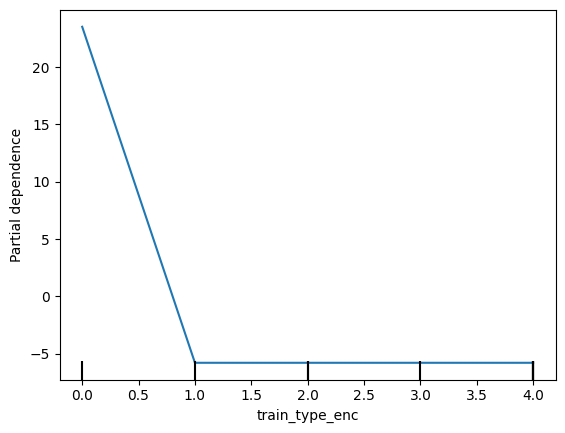

In [63]:
PartialDependenceDisplay.from_estimator(model, X_train, ["train_type_enc"])

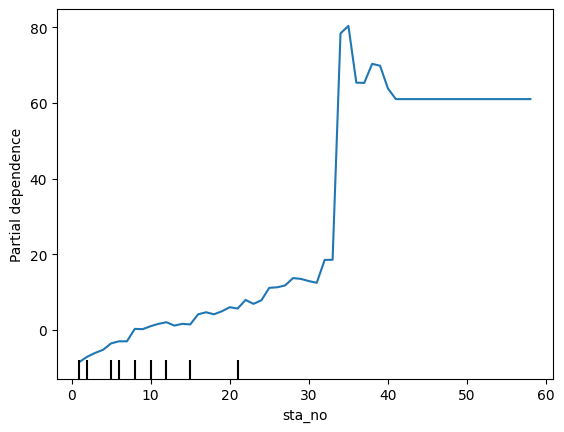

In [64]:
PartialDependenceDisplay.from_estimator(model, X_train, ["sta_no"])

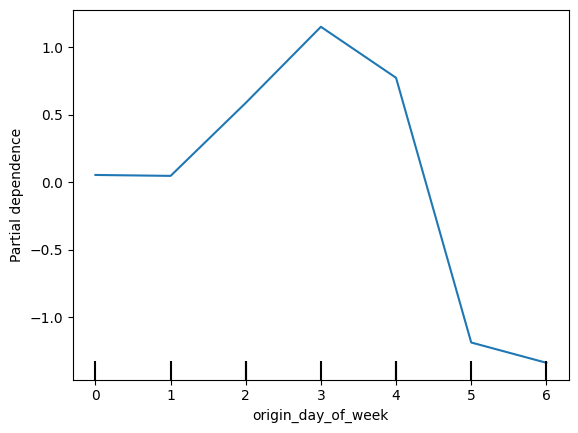

In [65]:
PartialDependenceDisplay.from_estimator(model, X_train, ["origin_day_of_week"])

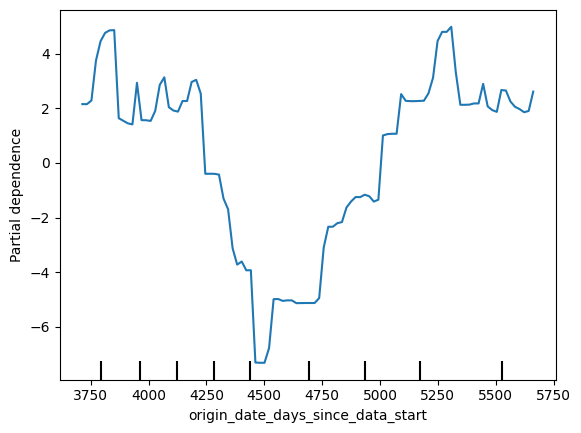

In [66]:
PartialDependenceDisplay.from_estimator(model, X_train, ["origin_date_days_since_data_start"])

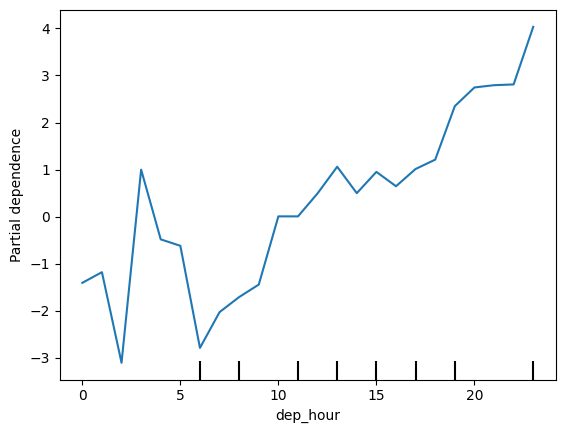

In [67]:
PartialDependenceDisplay.from_estimator(model, X_train, ["dep_hour"])

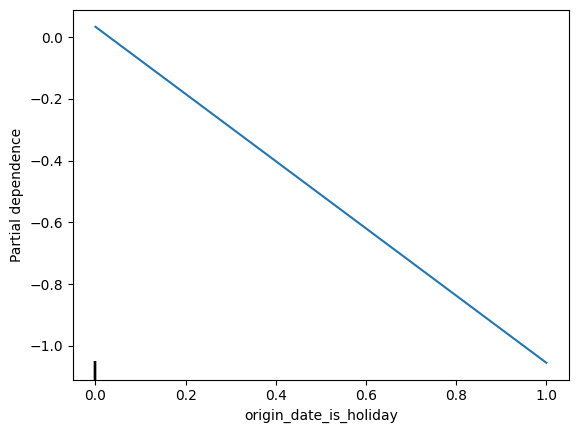

In [68]:
PartialDependenceDisplay.from_estimator(model, X_train, ["origin_date_is_holiday"])